# <font color="red">Icon Prediction with Support Vector Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

import sys
#sys.path.append('../../') # Uncomment this line if running locally
sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
#weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Parameters

In [9]:
grid_param = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

In [10]:
number_of_model_for_randomized_grid = 130
model_name_for_saving = "SVC"
target_name_for_saving = "Icon"
number_of_model_for_bagging = 100

# All Features

In [11]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Icon']

In [12]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Icon']

In [13]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [14]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## MinMax Scaler

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [16]:
X_train

array([[0.45454545, 0.2       , 0.04347826, ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.8       , 0.82608696, ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.9       , 0.86956522, ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.66666667, 0.13043478, ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.33333333, 0.47826087, ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.1       , 0.39130435, ..., 0.9903    , 0.471     ,
        0.07388643]])

In [17]:
X_test

array([[0.81818182, 1.        , 0.04347826, ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.33333333, 0.13043478, ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.63333333, 0.65217391, ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13333333, 0.13043478, ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.4       , 0.60869565, ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.23333333, 0.47826087, ..., 1.        , 0.119     ,
        0.07388643]])

### Default Parameters

In [18]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [19]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 7.55 s, sys: 175 ms, total: 7.73 s
Wall time: 7.72 s


SVC(probability=True, random_state=42)

In [20]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9401
Precision: 0.9412
Recall:    0.9401
F1-Score:  0.9277


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.96      0.96       301
        clear-night       0.99      0.93      0.96       362
             cloudy       0.95      0.16      0.27       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.91      0.98      0.94       774
partly-cloudy-night       0.90      0.98      0.94       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.82      0.72      0.73      2923
       weighted avg       0.94      0.94      0.93      2923



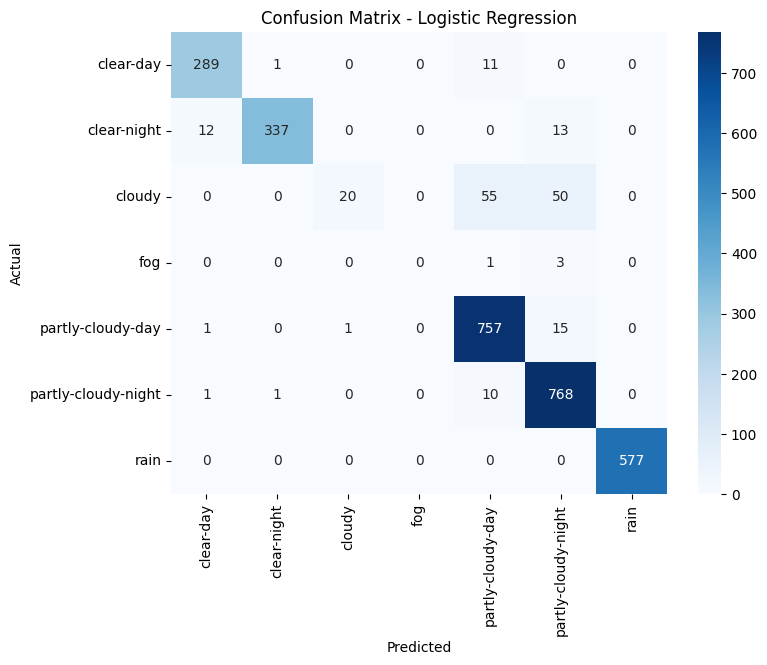

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9996
clear-night : 0.9995
cloudy   : 0.9921
fog      : 0.9836
partly-cloudy-day : 0.9973
partly-cloudy-night : 0.9979
rain     : 1.0000
Micro-avg : 0.9988


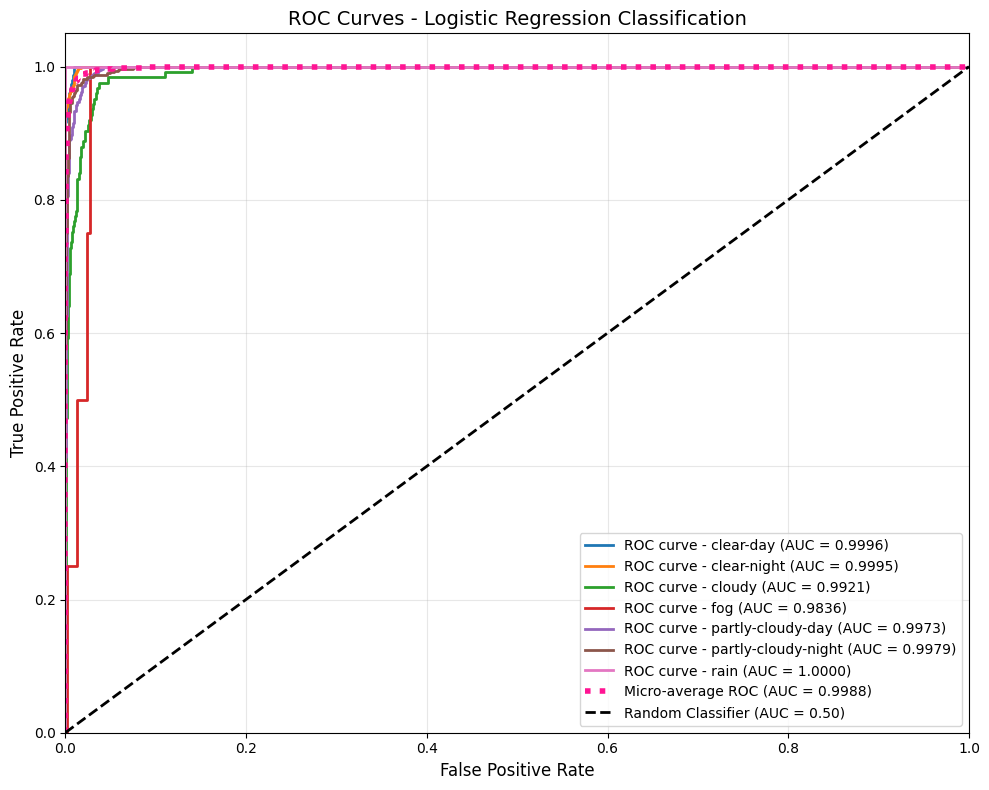

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9983
One-vs-One (Weighted)  : 0.9944
Micro-average          : 0.9988


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.940130, F1: 0.927667, AUC (micro-avg): 0.998812
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 44.7 s, sys: 7.57 s, total: 52.2 s
Wall time: 1h 20min 55s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best parameters as an array
grid_param_minmax = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9824492169923564


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

In [36]:
y_pred_grid

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [37]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9867
Precision: 0.9854
Recall:    0.9867
F1-Score:  0.9860


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



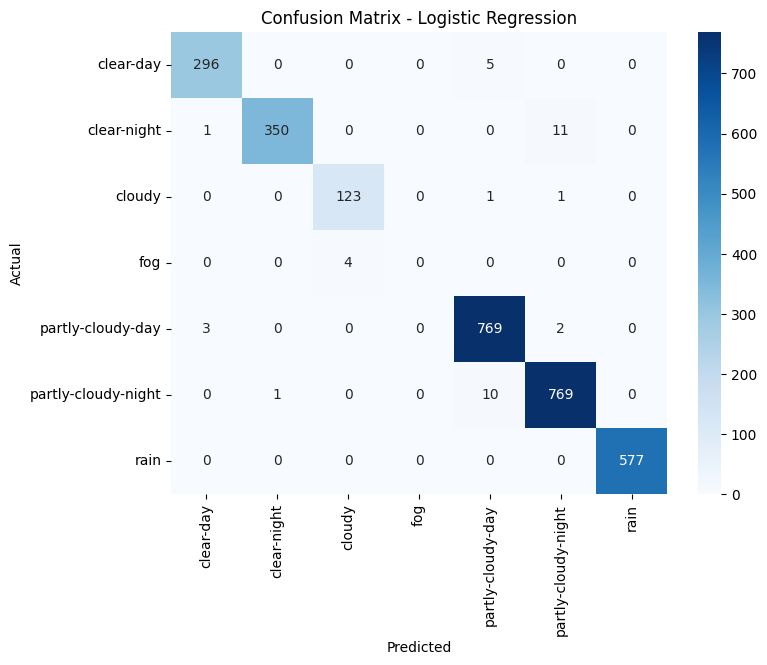

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9998
cloudy   : 0.9900
fog      : 0.9538
partly-cloudy-day : 0.9990
partly-cloudy-night : 0.9989
rain     : 1.0000
Micro-avg : 0.9991


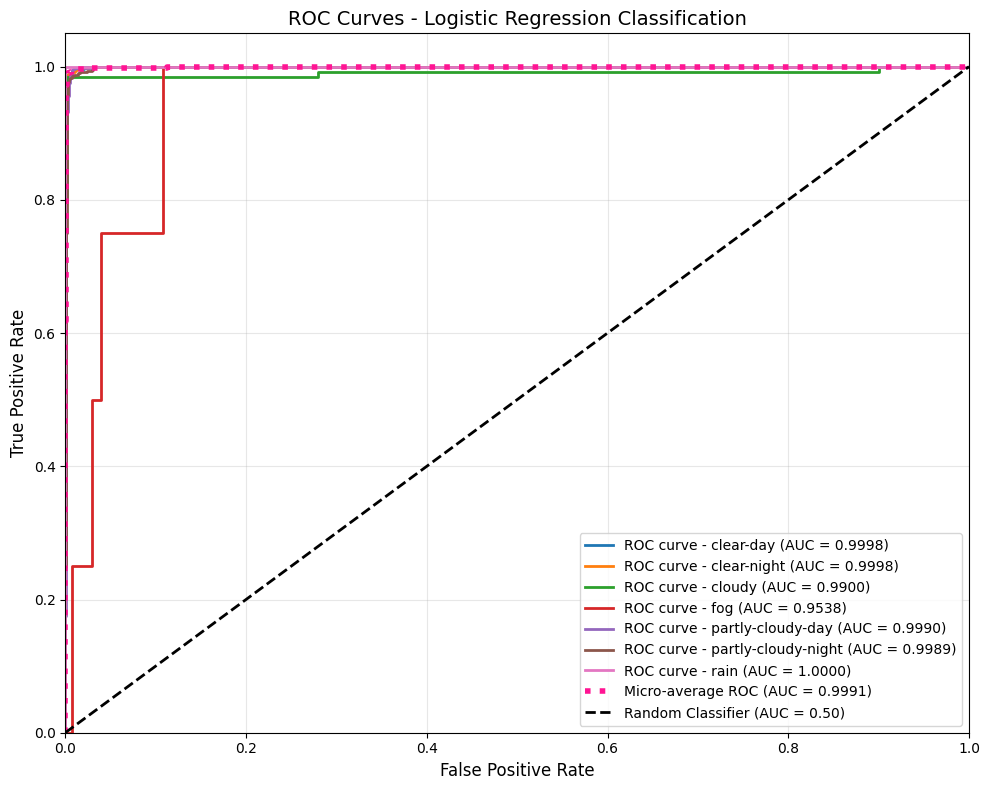

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9932
Micro-average          : 0.9991


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.986658, F1: 0.985978, AUC (micro-avg): 0.999089
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.6min remaining:  4.6min


CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 4min 39s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.7min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.6s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9658
Precision: 0.9647
Recall:    0.9658
F1-Score:  0.9640


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.97      0.96      0.97       301
        clear-night       0.99      0.94      0.97       362
             cloudy       0.94      0.67      0.79       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.95      0.98      0.97       774
partly-cloudy-night       0.95      0.99      0.97       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.97      2923
          macro avg       0.83      0.79      0.81      2923
       weighted avg       0.96      0.97      0.96      2923



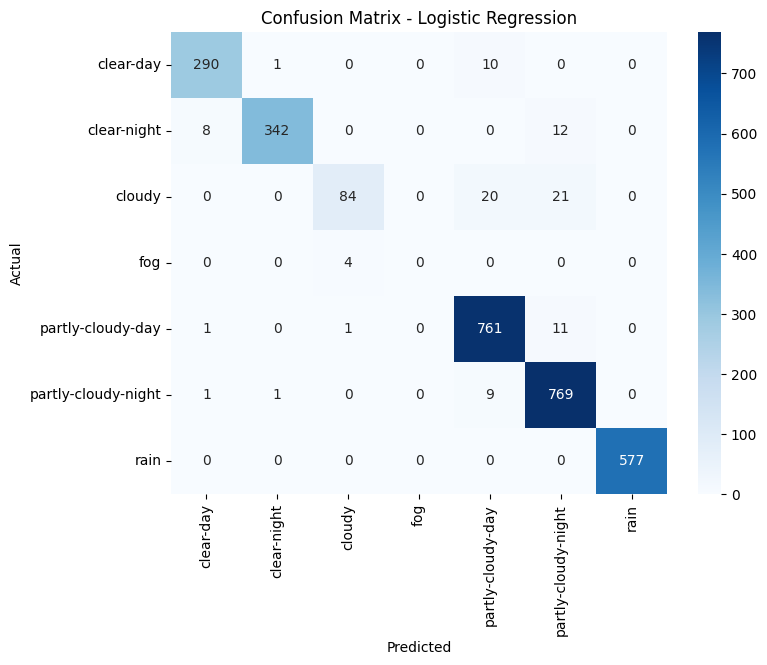

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.6s remaining:   34.6s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.3s finished


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9993
clear-night : 0.9989
cloudy   : 0.9947
fog      : 0.9967
partly-cloudy-day : 0.9968
partly-cloudy-night : 0.9963
rain     : 1.0000
Micro-avg : 0.9976


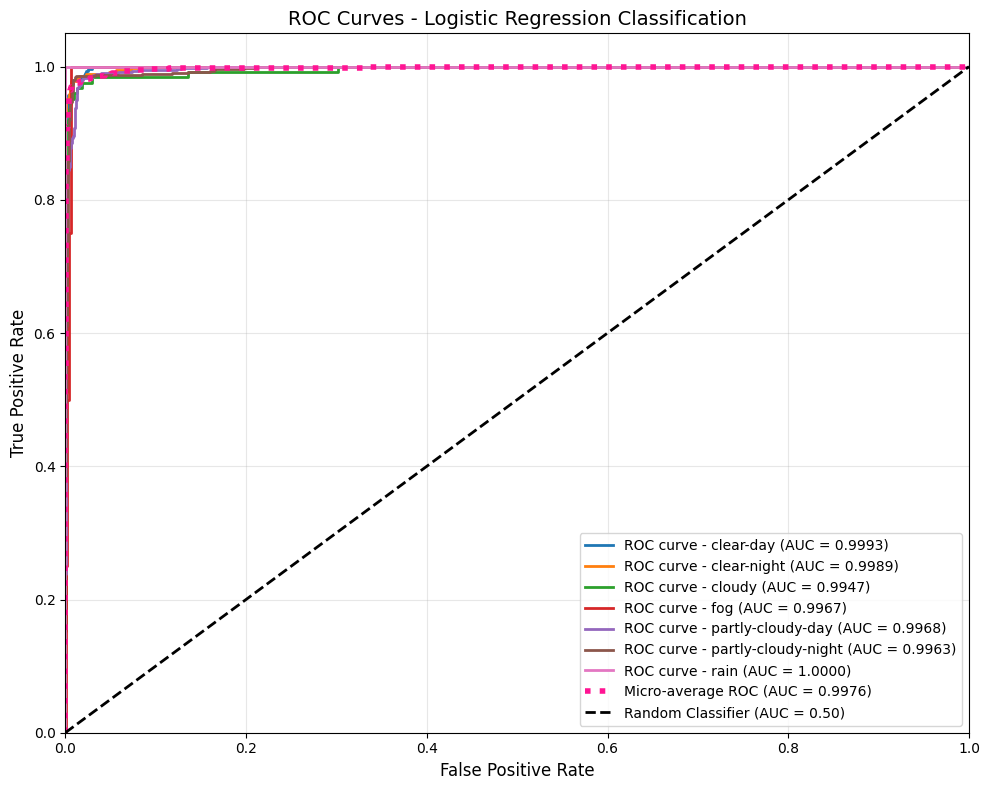

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9977
One-vs-One (Weighted)  : 0.9945
Micro-average          : 0.9976


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.965789, F1: 0.964021, AUC (micro-avg): 0.997561
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [63]:
X_train

array([[ 0.08873237, -0.9946814 , -1.51753864, ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.04440482,  1.07523376, ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.38425252,  1.21927667, ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591,  0.59127454, -1.22945281, ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.54155113, -0.07710953, ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -1.33452911, -0.36519535, ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [64]:
X_test

array([[ 1.33830651,  1.72410022, -1.51753864, ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -0.54155113, -1.22945281, ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.47799198,  0.49906212, ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22124654, -1.22945281, ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004, -0.314986  ,  0.35501921, ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.88139884, -0.07710953, ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

### Default Parameters

In [65]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [66]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


SVC(probability=True, random_state=42)

In [67]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [68]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9412
Precision: 0.9409
Recall:    0.9412
F1-Score:  0.9294


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.96      0.96       301
        clear-night       0.99      0.93      0.96       362
             cloudy       0.92      0.18      0.30       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.91      0.98      0.94       774
partly-cloudy-night       0.91      0.98      0.94       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.81      0.72      0.73      2923
       weighted avg       0.94      0.94      0.93      2923



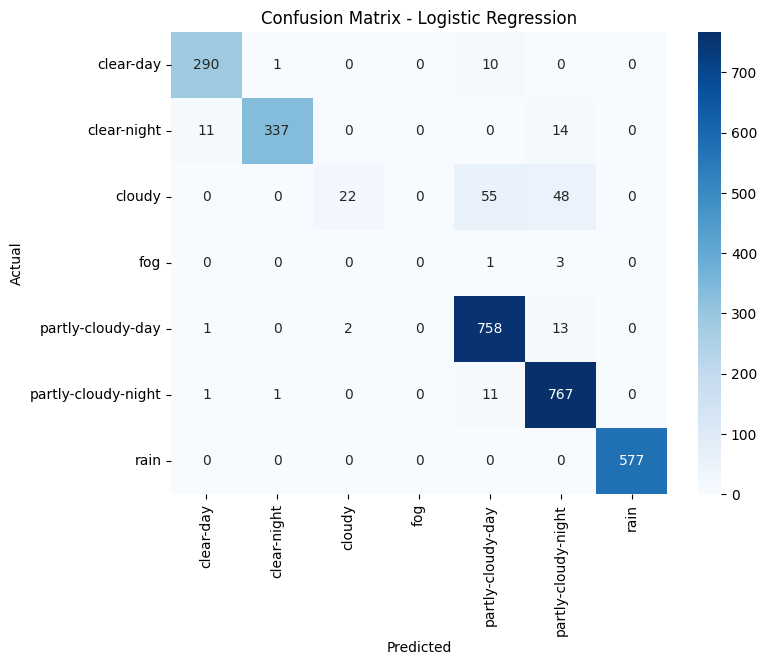

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9994
cloudy   : 0.9813
fog      : 0.9909
partly-cloudy-day : 0.9964
partly-cloudy-night : 0.9970
rain     : 1.0000
Micro-avg : 0.9984


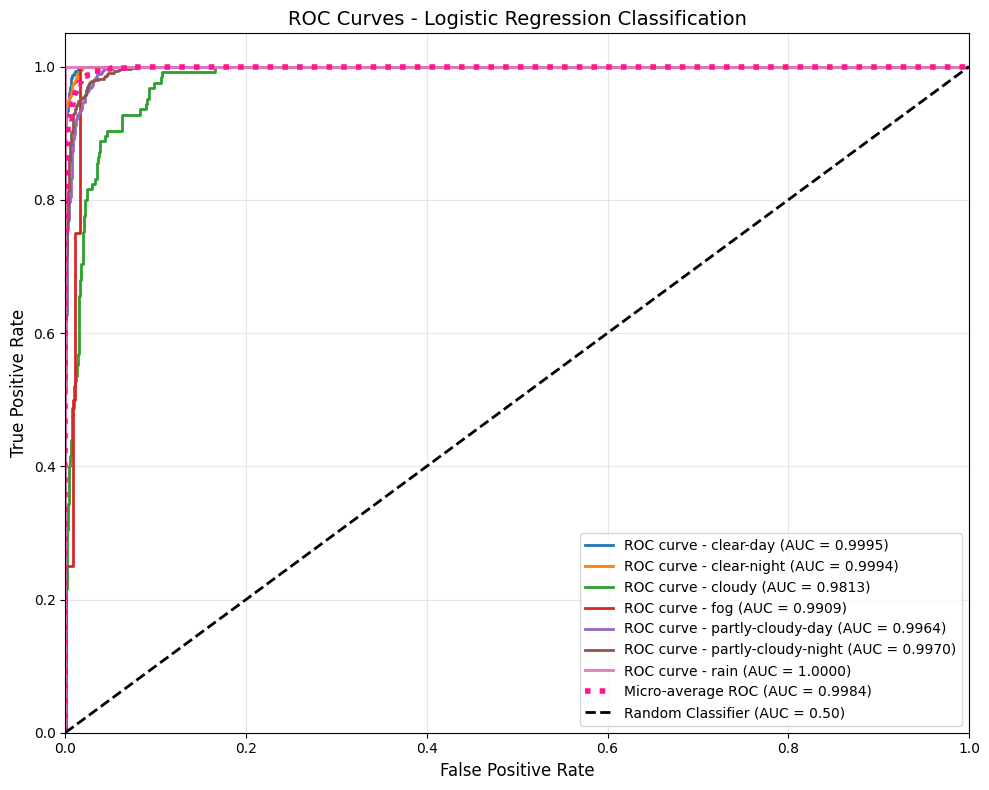

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9973
One-vs-One (Weighted)  : 0.9930
Micro-average          : 0.9984


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.941156, F1: 0.929385, AUC (micro-avg): 0.998437
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 3min 21s, sys: 10.3 s, total: 3min 31s
Wall time: 1h 24min 24s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to train the robust scaler model
grid_param_standard = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9844052697589637


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9856
Precision: 0.9843
Recall:    0.9856
F1-Score:  0.9850


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       0.99      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.98      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.98      0.99      0.98      2923



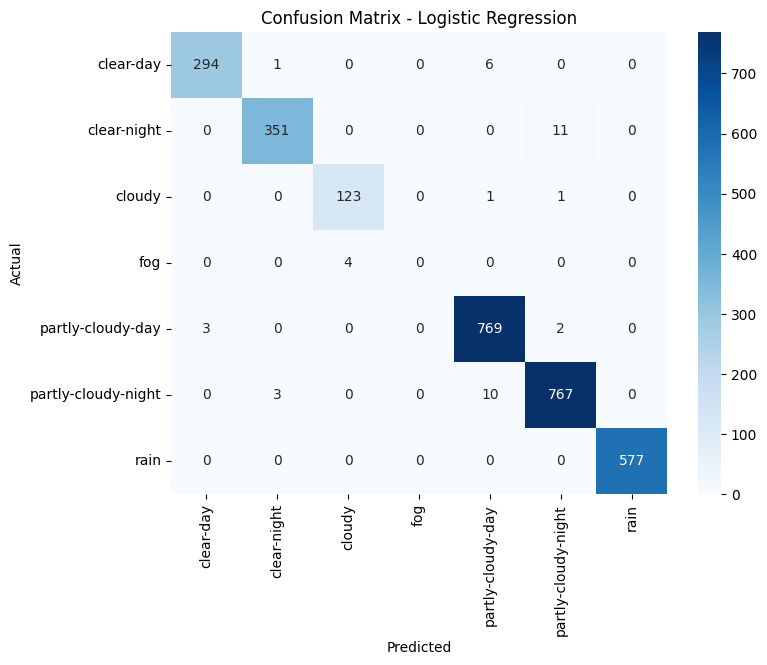

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9997
cloudy   : 0.9893
fog      : 0.9579
partly-cloudy-day : 0.9990
partly-cloudy-night : 0.9991
rain     : 1.0000
Micro-avg : 0.9991


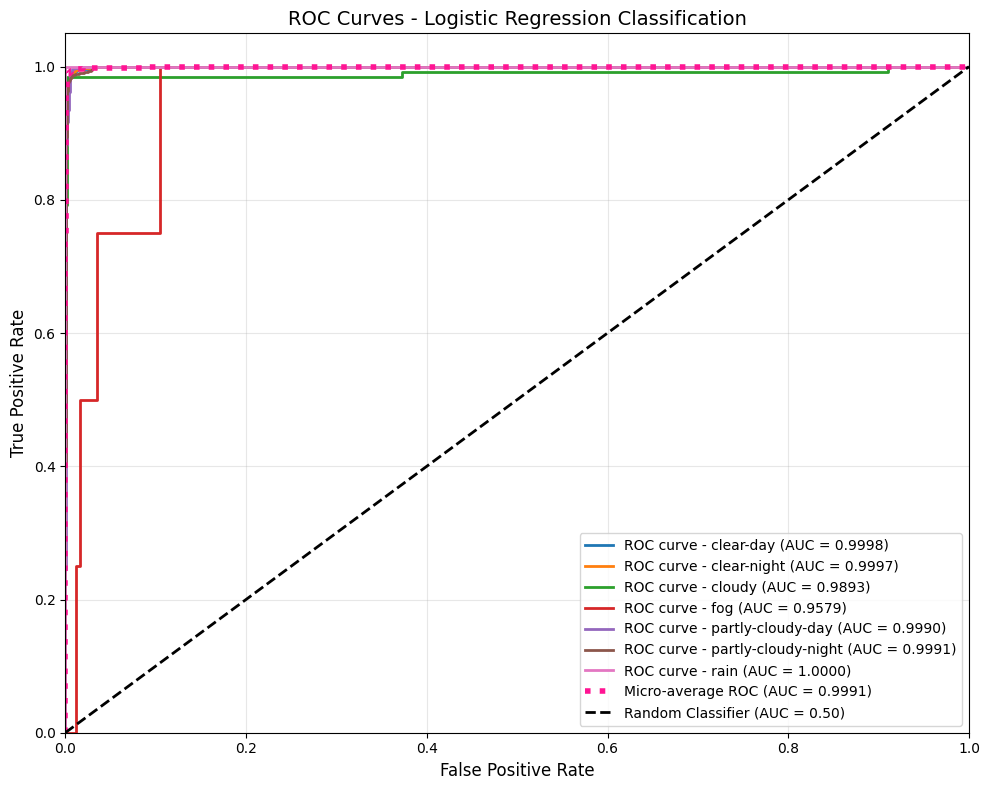

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9938
Micro-average          : 0.9991


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.985631, F1: 0.984951, AUC (micro-avg): 0.999133
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.9min remaining:  4.9min


CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 5min 3s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  5.0min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.7s remaining:   33.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.8s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9607
Precision: 0.9606
Recall:    0.9607
F1-Score:  0.9575


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.96      0.96       301
        clear-night       0.99      0.95      0.97       362
             cloudy       0.99      0.54      0.70       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.94      0.98      0.96       774
partly-cloudy-night       0.94      0.99      0.96       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.96      2923
          macro avg       0.83      0.77      0.79      2923
       weighted avg       0.96      0.96      0.96      2923



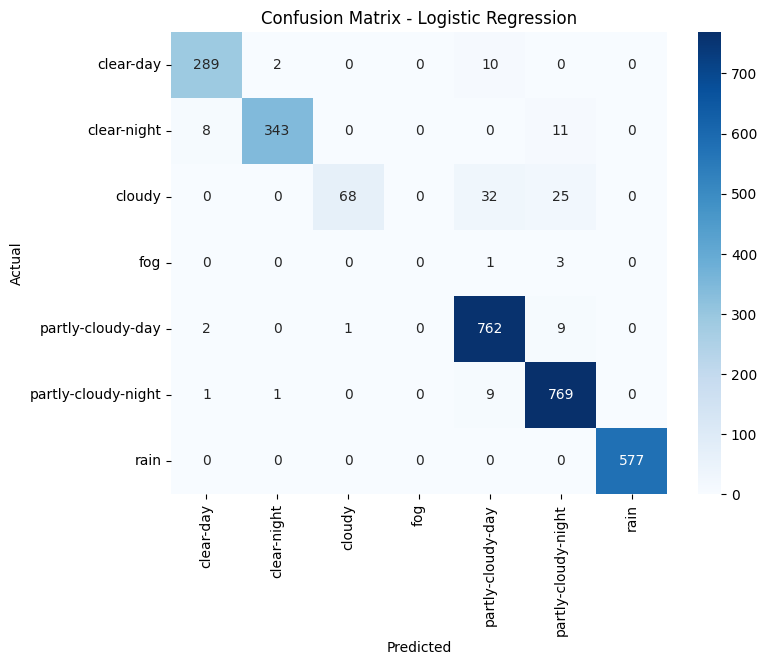

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.0s remaining:   33.0s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.6s finished


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9993
clear-night : 0.9989
cloudy   : 0.9942
fog      : 0.9961
partly-cloudy-day : 0.9972
partly-cloudy-night : 0.9964
rain     : 1.0000
Micro-avg : 0.9978


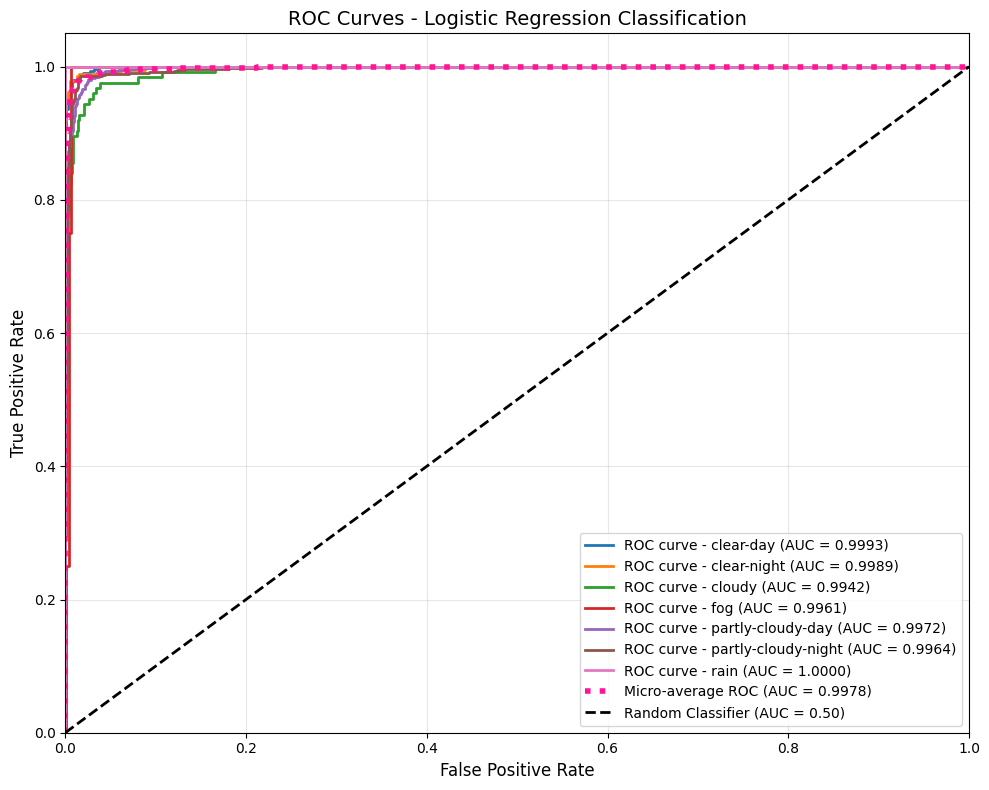

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9978
One-vs-One (Weighted)  : 0.9954
Micro-average          : 0.9978


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.960657, F1: 0.957527, AUC (micro-avg): 0.997810
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [108]:
X_train

array([[ 0.00000000e+00, -6.00000000e-01, -9.16666667e-01, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  6.00000000e-01,  5.83333333e-01, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  8.00000000e-01,  6.66666667e-01, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01,  3.33333333e-01, -7.50000000e-01, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.33333333e-01, -8.33333333e-02, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -8.00000000e-01, -2.50000000e-01, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [109]:
X_test

array([[ 0.8       ,  1.        , -0.91666667, ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.33333333, -0.75      , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.26666667,  0.25      , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.73333333, -0.75      , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        , -0.2       ,  0.16666667, ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.53333333, -0.08333333, ...,  0.79384817,
         0.25757576,  0.        ]])

### Default Parameters

In [110]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [111]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 40.5 s, sys: 0 ns, total: 40.5 s
Wall time: 40.5 s


SVC(probability=True, random_state=42)

In [112]:
y_pred = training_model.predict(X_test)
y_pred

array(['partly-cloudy-night', 'rain', 'rain', ..., 'rain',
       'partly-cloudy-day', 'rain'], dtype=object)

In [113]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6654
Precision: 0.5178
Recall:    0.6654
F1-Score:  0.5720


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.00      0.00      0.00       301
        clear-night       0.00      0.00      0.00       362
             cloudy       0.00      0.00      0.00       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.67      0.76      0.72       774
partly-cloudy-night       0.53      1.00      0.69       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.67      2923
          macro avg       0.32      0.39      0.34      2923
       weighted avg       0.52      0.67      0.57      2923



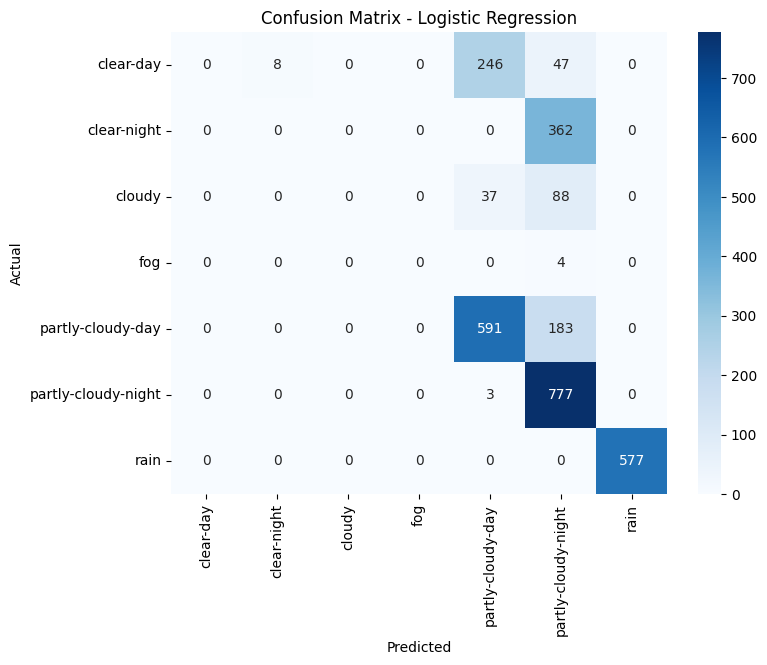

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9760
clear-night : 0.9626
cloudy   : 0.9281
fog      : 0.9454
partly-cloudy-day : 0.9687
partly-cloudy-night : 0.9735
rain     : 1.0000
Micro-avg : 0.9828


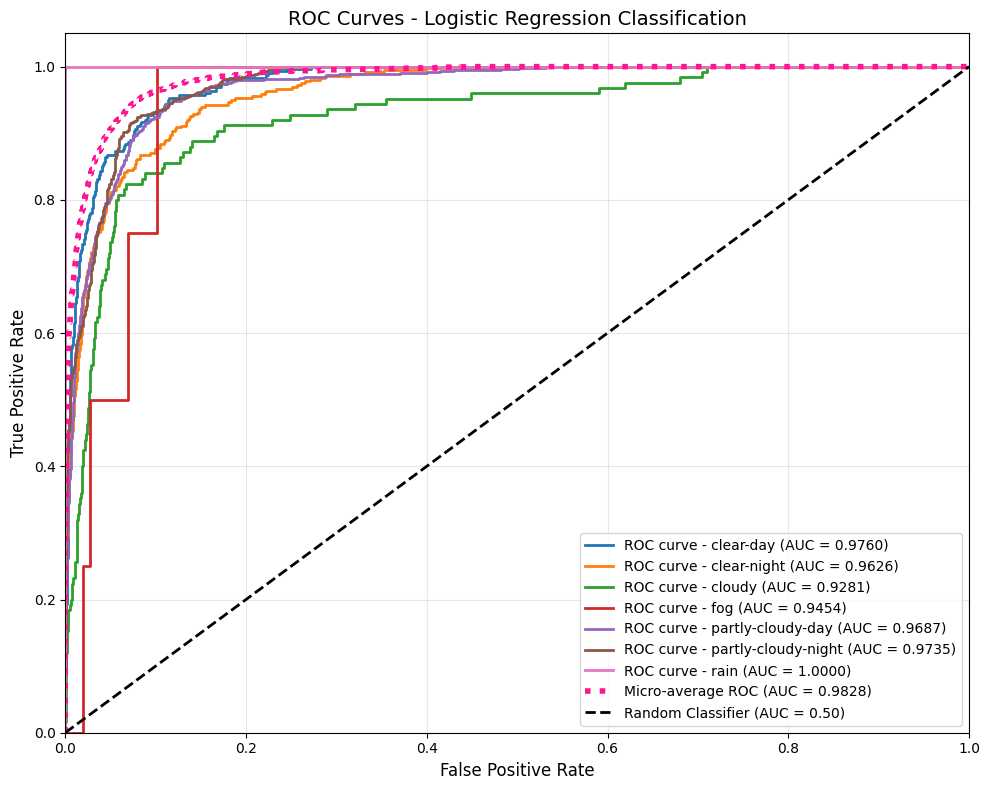

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9744
One-vs-One (Weighted)  : 0.9581
Micro-average          : 0.9828


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.665412, F1: 0.572020, AUC (micro-avg): 0.982828
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_param_robust = [grid_param_minmax, grid_param_standard]

In [125]:
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param_robust,
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, # allow parallel processing, you cant use your own laptop while this runs
    verbose=1,
    return_train_score=True
)

grid_search

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [126]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 7min 46s, sys: 1.88 s, total: 7min 48s
Wall time: 33min 23s


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [127]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'C': 100, 'class_weight': None, 'coef0': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.9836387326286065


In [128]:
y_pred_grid = best_grid_model.predict(X_test)

In [129]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [130]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9856
Precision: 0.9843
Recall:    0.9856
F1-Score:  0.9850


In [131]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       0.99      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.98      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.98      0.99      0.98      2923



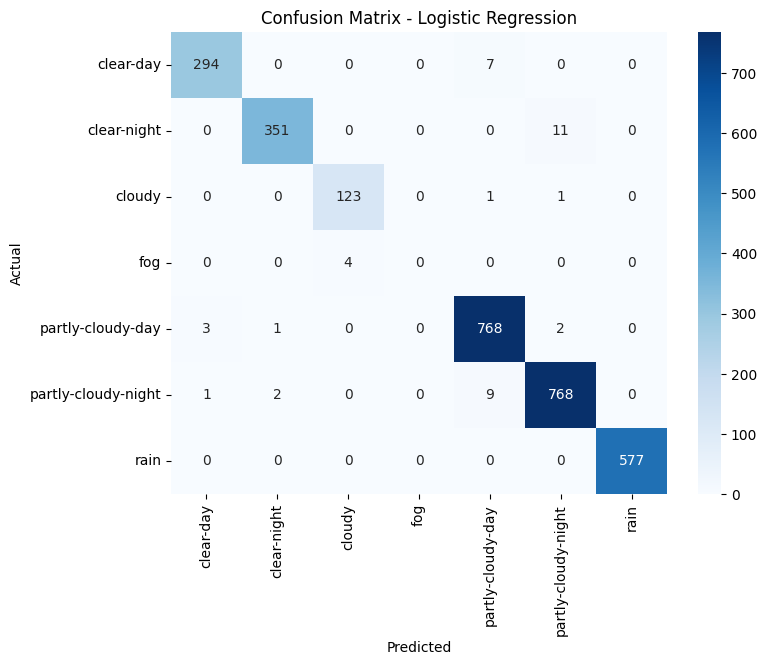

In [132]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [133]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [134]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [135]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9998
cloudy   : 0.9906
fog      : 0.9731
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9988
rain     : 1.0000
Micro-avg : 0.9992


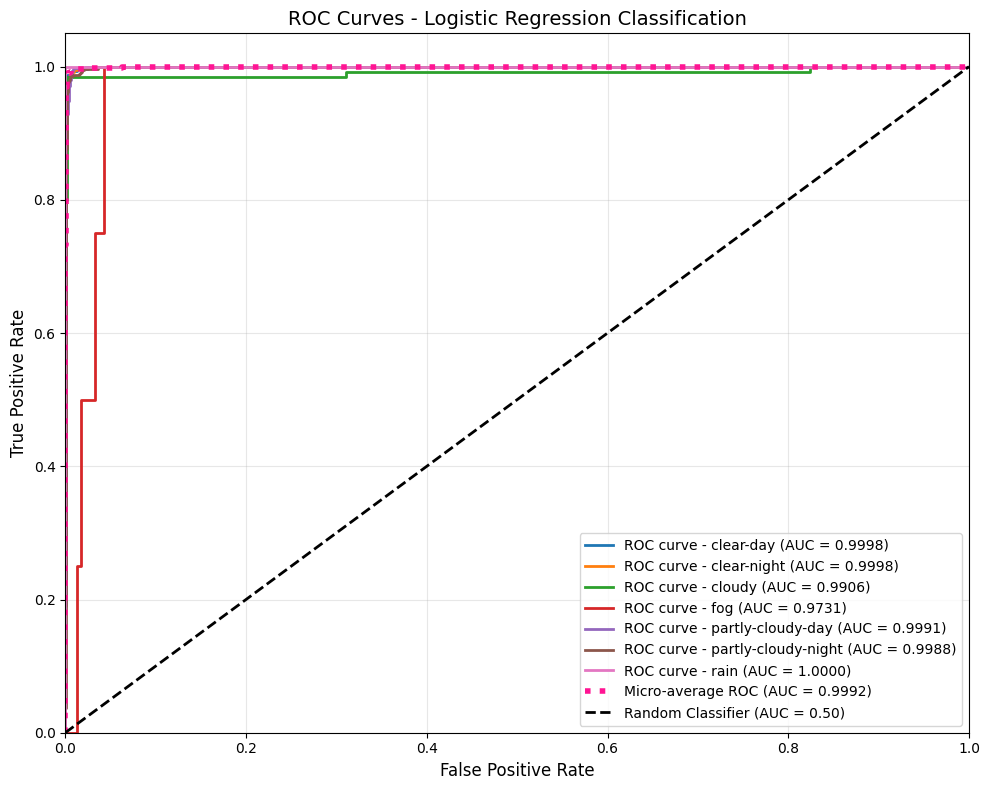

In [136]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [137]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9952
Micro-average          : 0.9992


In [138]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.985631, F1: 0.984952, AUC (micro-avg): 0.999182
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [139]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [140]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [141]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  9.6min remaining:  9.6min


CPU times: user 4.09 s, sys: 835 ms, total: 4.93 s
Wall time: 9min 42s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.7min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [142]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   52.1s remaining:   52.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   53.2s finished


In [143]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [144]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9196
Precision: 0.9183
Recall:    0.9196
F1-Score:  0.9090


In [145]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.89      0.91      0.90       301
        clear-night       0.93      0.90      0.92       362
             cloudy       0.89      0.20      0.33       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.90      0.95      0.92       774
partly-cloudy-night       0.90      0.96      0.93       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.92      2923
          macro avg       0.79      0.70      0.71      2923
       weighted avg       0.92      0.92      0.91      2923



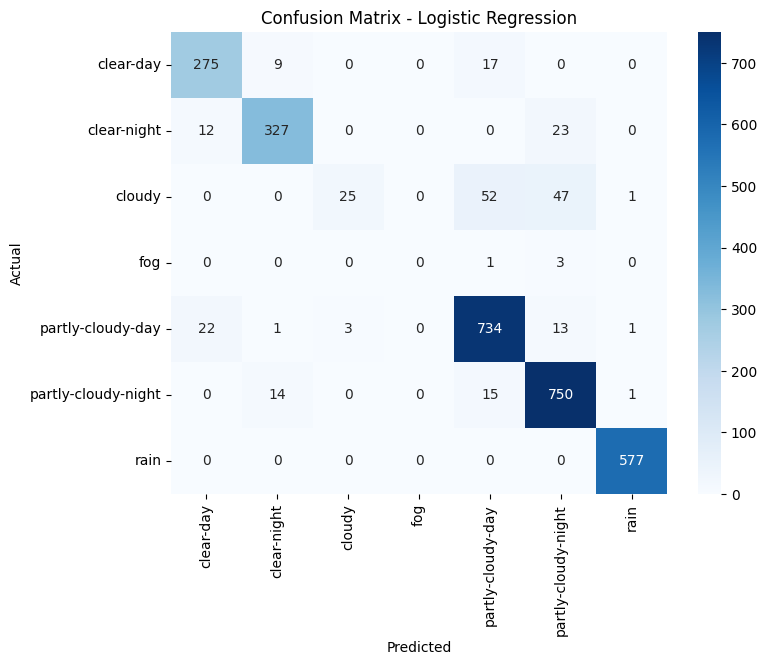

In [146]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [147]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   51.9s remaining:   51.9s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.9s finished


In [148]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [149]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9955
clear-night : 0.9940
cloudy   : 0.9833
fog      : 0.9870
partly-cloudy-day : 0.9896
partly-cloudy-night : 0.9930
rain     : 1.0000
Micro-avg : 0.9948


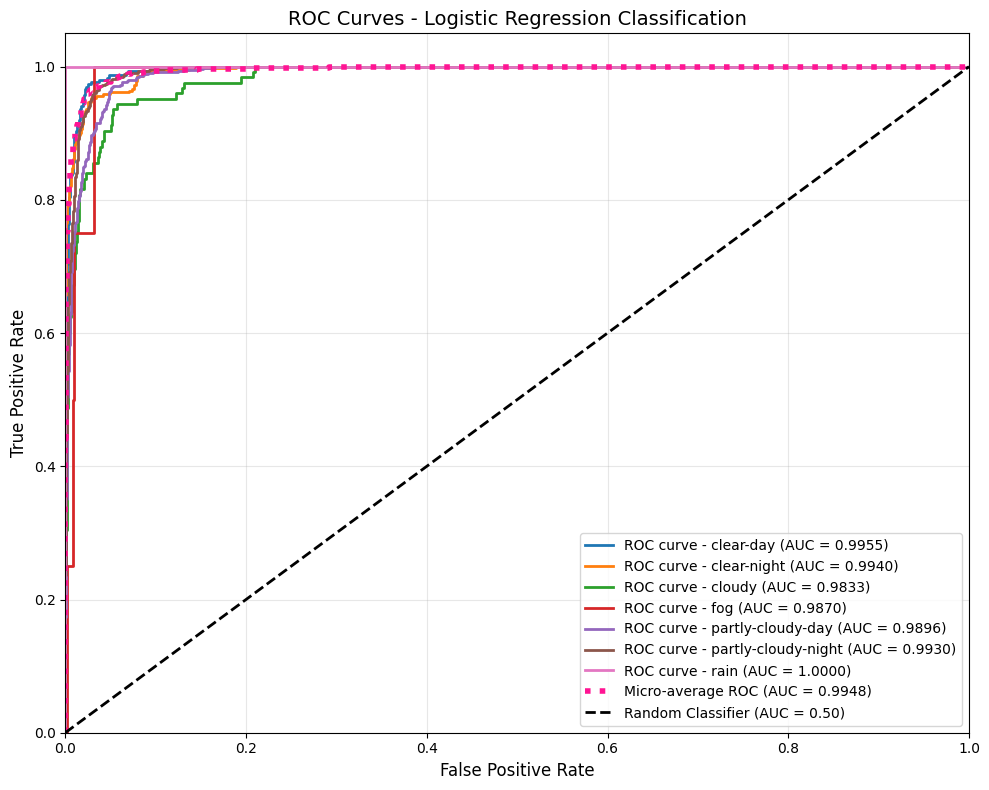

In [150]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [151]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9934
One-vs-One (Weighted)  : 0.9874
Micro-average          : 0.9948


In [152]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.919603, F1: 0.909021, AUC (micro-avg): 0.994800
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [153]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [154]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [155]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [156]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [157]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


### MinMax Scaler

In [158]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [159]:
X_train

array([[0.45454545, 0.04347826, 0.        , ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.82608696, 0.        , ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.13043478, 0.        , ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.47826087, 0.        , ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.39130435, 0.        , ..., 0.9903    , 0.471     ,
        0.07388643]])

In [160]:
X_test

array([[0.81818182, 0.04347826, 0.        , ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.13043478, 0.        , ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.65217391, 1.        , ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13043478, 0.        , ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.60869565, 1.        , ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.47826087, 0.        , ..., 1.        , 0.119     ,
        0.07388643]])

#### Default Parameters

In [161]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [162]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 6.21 s, sys: 0 ns, total: 6.21 s
Wall time: 6.19 s


SVC(probability=True, random_state=42)

In [163]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [164]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [165]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [166]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9394
Precision: 0.9426
Recall:    0.9394
F1-Score:  0.9252


In [167]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.96      0.96       301
        clear-night       1.00      0.93      0.96       362
             cloudy       1.00      0.12      0.21       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.90      0.98      0.94       774
partly-cloudy-night       0.90      0.99      0.94       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.82      0.71      0.72      2923
       weighted avg       0.94      0.94      0.93      2923



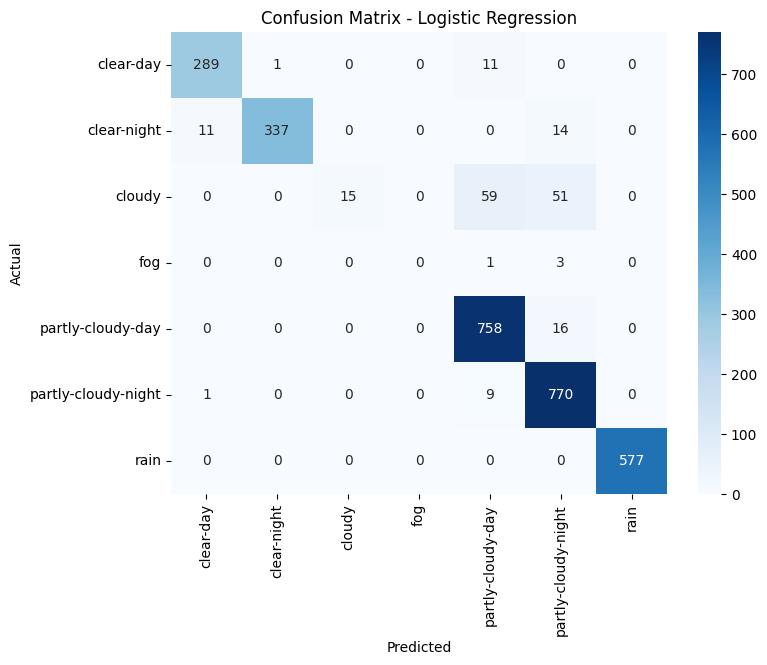

In [168]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [169]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [170]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [171]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9995
cloudy   : 0.9930
fog      : 0.9811
partly-cloudy-day : 0.9975
partly-cloudy-night : 0.9982
rain     : 1.0000
Micro-avg : 0.9988


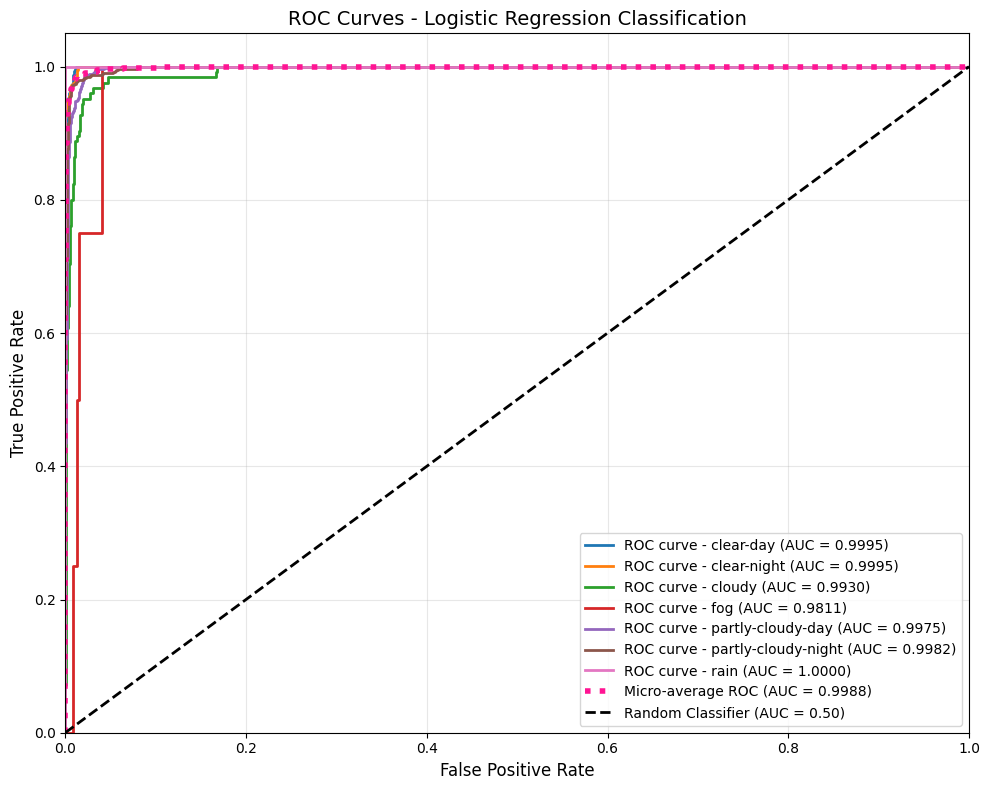

In [172]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [173]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9984
One-vs-One (Weighted)  : 0.9944
Micro-average          : 0.9988


In [174]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.940130 ≈ 0.939446 (similar)
   F1-Score: 0.927667 ≈ 0.925205 (similar)
   AUC (micro-avg): 0.998812 ≈ 0.998823
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [175]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [176]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 44.3 s, sys: 9.29 s, total: 53.6 s
Wall time: 1h 14min 5s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [177]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best parameters as an array
grid_param_minmax = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9827642469845881


In [178]:
y_pred_grid = best_grid_model.predict(X_test)

In [179]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [180]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9856
Precision: 0.9844
Recall:    0.9856
F1-Score:  0.9849


In [181]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.98      0.98      0.98       301
        clear-night       1.00      0.96      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.98      0.99      0.98      2923



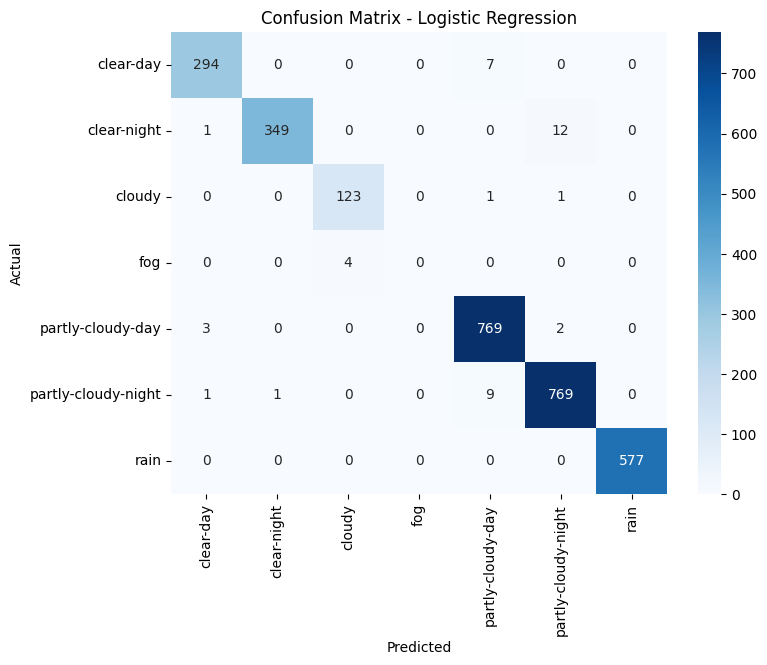

In [182]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [183]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [184]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [185]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9998
cloudy   : 0.9911
fog      : 0.8865
partly-cloudy-day : 0.9990
partly-cloudy-night : 0.9990
rain     : 1.0000
Micro-avg : 0.9991


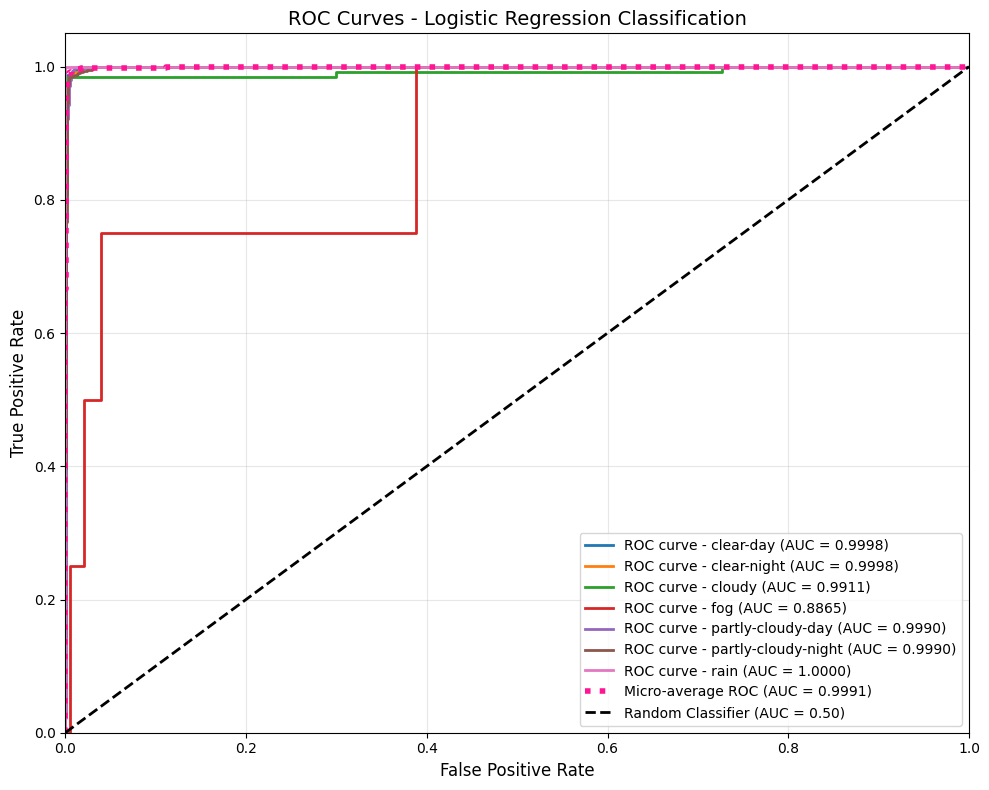

In [186]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [187]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9873
Micro-average          : 0.9991


In [188]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.986658 ≈ 0.985631 (similar)
   F1-Score: 0.985978 ≈ 0.984948 (similar)
   AUC (micro-avg): 0.999089 ≈ 0.999131
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [189]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [190]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [191]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.4min remaining:  4.4min


CPU times: user 1.63 s, sys: 817 ms, total: 2.45 s
Wall time: 4min 48s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.8min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [192]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.2s remaining:   34.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.3s finished


In [193]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [194]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9583
Precision: 0.9577
Recall:    0.9583
F1-Score:  0.9555


In [195]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.95      0.95       301
        clear-night       0.99      0.94      0.96       362
             cloudy       0.96      0.57      0.71       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.94      0.98      0.96       774
partly-cloudy-night       0.94      0.98      0.96       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.96      2923
          macro avg       0.83      0.77      0.79      2923
       weighted avg       0.96      0.96      0.96      2923



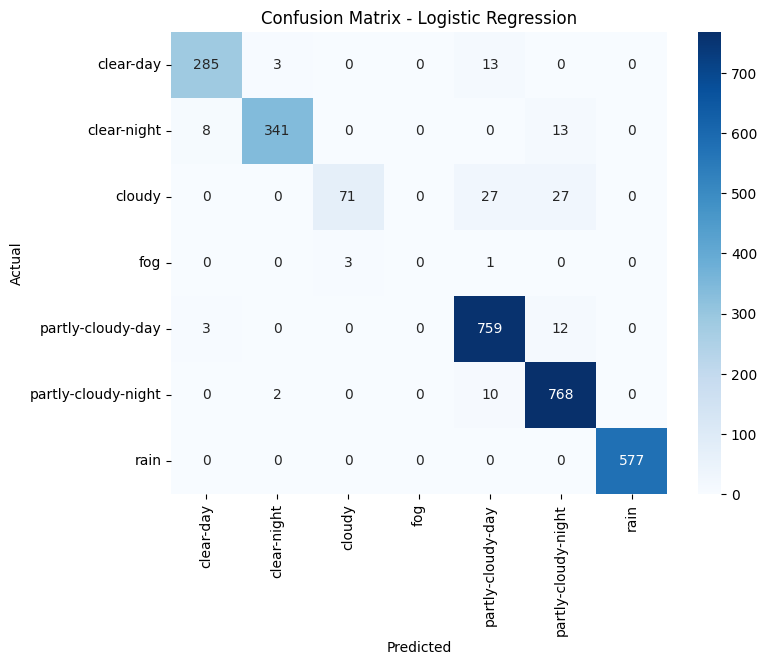

In [196]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [197]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.2s remaining:   34.2s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.8s finished


In [198]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [199]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9983
clear-night : 0.9975
cloudy   : 0.9950
fog      : 0.9966
partly-cloudy-day : 0.9956
partly-cloudy-night : 0.9950
rain     : 1.0000
Micro-avg : 0.9963


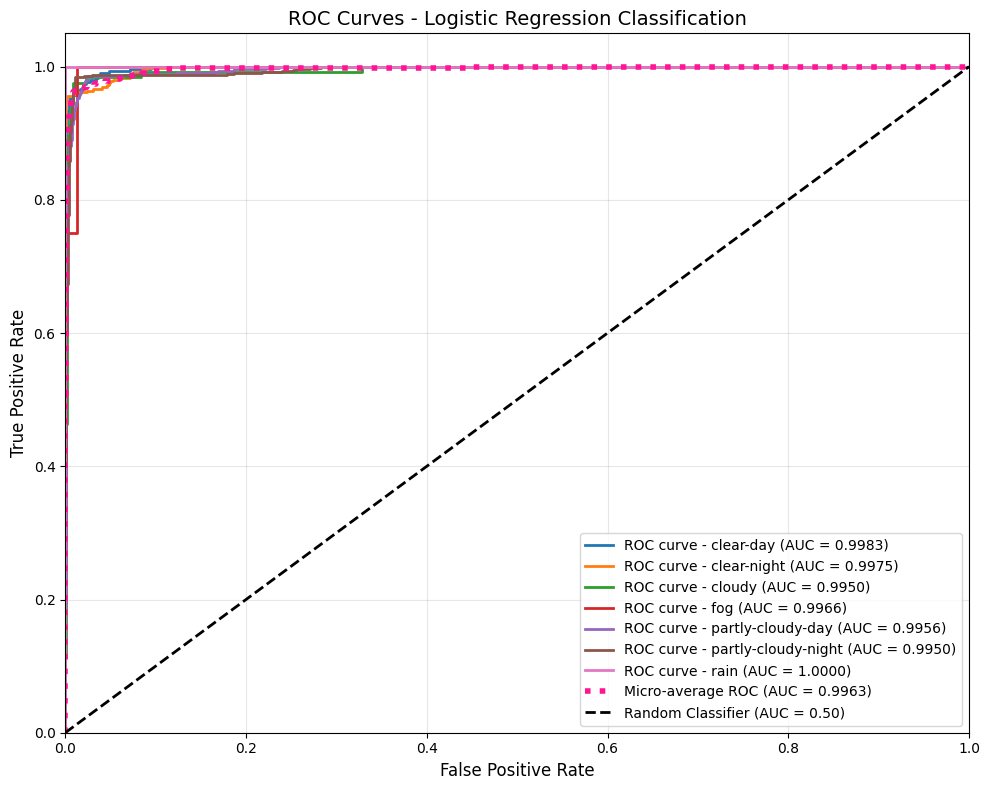

In [200]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [201]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9968
One-vs-One (Weighted)  : 0.9936
Micro-average          : 0.9963


In [202]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.965789 ≈ 0.958262 (similar)
   F1-Score: 0.964021 ≈ 0.955470 (similar)
   AUC (micro-avg): 0.997561 ≈ 0.996330
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Standard Scaler

In [203]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [204]:
X_train

array([[ 0.08873237, -1.51753864, -0.3888967 , ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.07523376, -0.3888967 , ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.21927667, -0.3888967 , ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591, -1.22945281, -0.3888967 , ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.07710953, -0.3888967 , ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -0.36519535, -0.3888967 , ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [205]:
X_test

array([[ 1.33830651, -1.51753864, -0.3888967 , ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -1.22945281, -0.3888967 , ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.49906212,  2.5713769 , ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22945281, -0.3888967 , ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004,  0.35501921,  2.5713769 , ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.07710953, -0.3888967 , ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

#### Default Parameters

In [206]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [207]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 7.88 s, sys: 0 ns, total: 7.88 s
Wall time: 7.87 s


SVC(probability=True, random_state=42)

In [208]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [209]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [210]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [211]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9425
Precision: 0.9418
Recall:    0.9425
F1-Score:  0.9304


In [212]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.95      0.96       301
        clear-night       0.99      0.94      0.96       362
             cloudy       0.91      0.17      0.28       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.91      0.99      0.95       774
partly-cloudy-night       0.91      0.98      0.95       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.81      0.72      0.73      2923
       weighted avg       0.94      0.94      0.93      2923



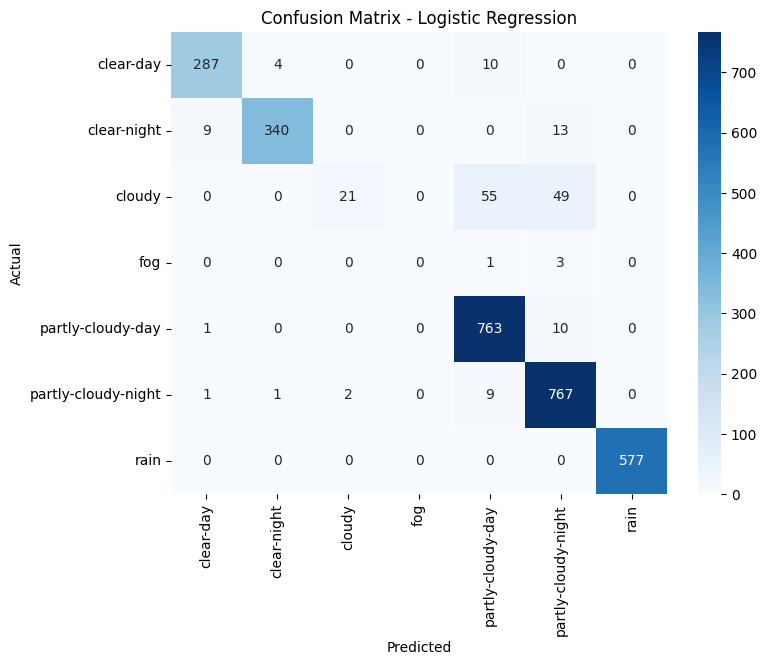

In [213]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [214]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [215]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [216]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9994
cloudy   : 0.9886
fog      : 0.9866
partly-cloudy-day : 0.9971
partly-cloudy-night : 0.9976
rain     : 1.0000
Micro-avg : 0.9986


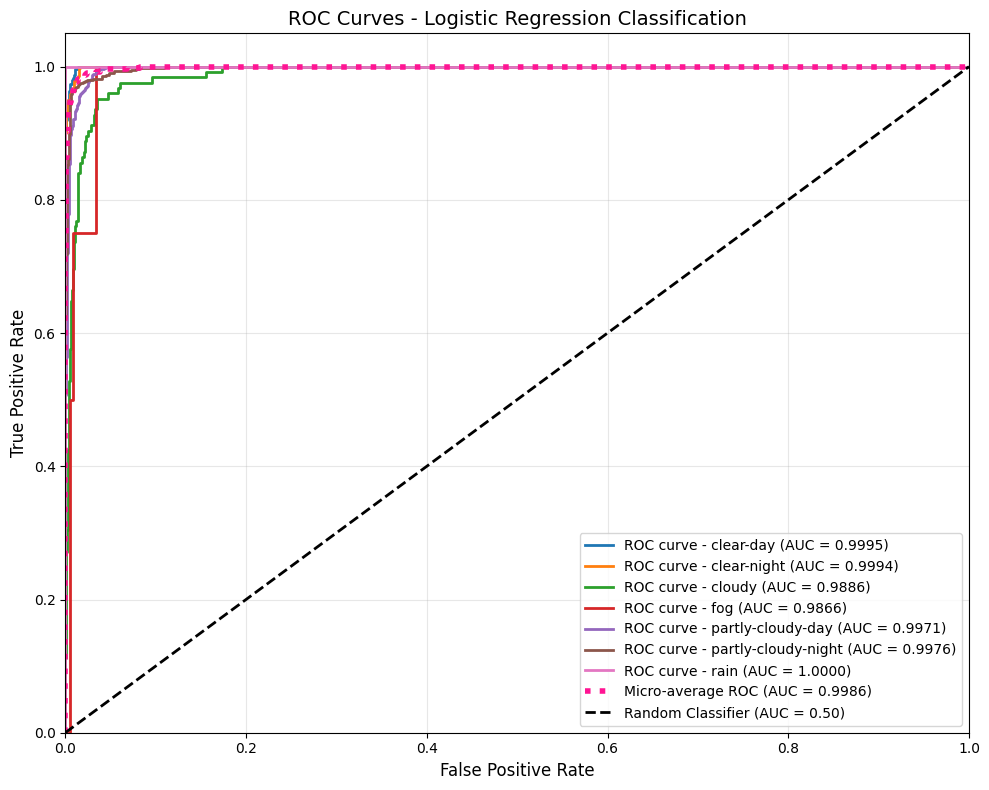

In [217]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [218]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9980
One-vs-One (Weighted)  : 0.9942
Micro-average          : 0.9986


In [219]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.941156 → 0.942525
   F1-Score: 0.929385 → 0.930371
   AUC (micro-avg): 0.998437 → 0.998559
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [220]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [221]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 2min 44s, sys: 8.41 s, total: 2min 53s
Wall time: 1h 11min 29s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [222]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to train the robust scaler model
grid_param_standard = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9849313735766421


In [223]:
y_pred_grid = best_grid_model.predict(X_test)

In [224]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [225]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9860
Precision: 0.9847
Recall:    0.9860
F1-Score:  0.9853


In [226]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       0.99      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.98      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.98      0.99      0.99      2923



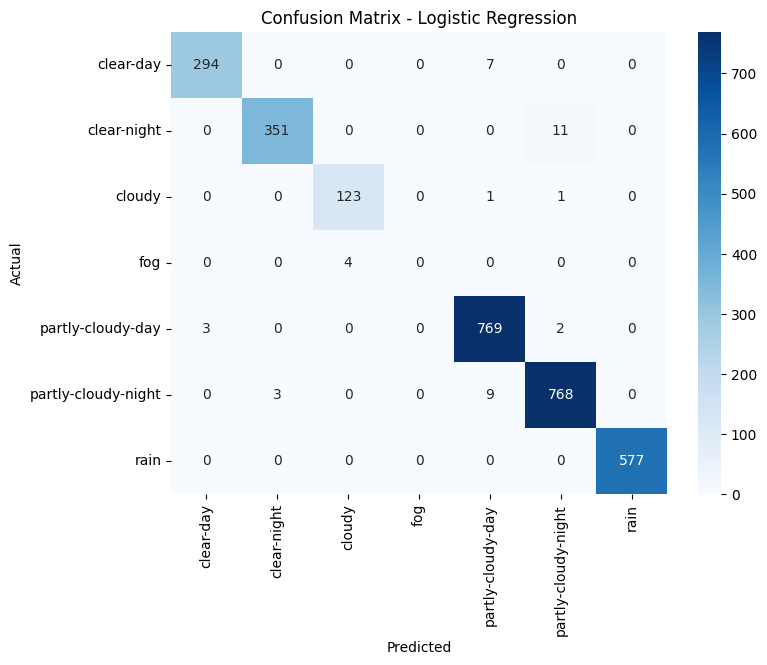

In [227]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [228]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [229]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [230]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9997
cloudy   : 0.9897
fog      : 0.9710
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9990
rain     : 1.0000
Micro-avg : 0.9992


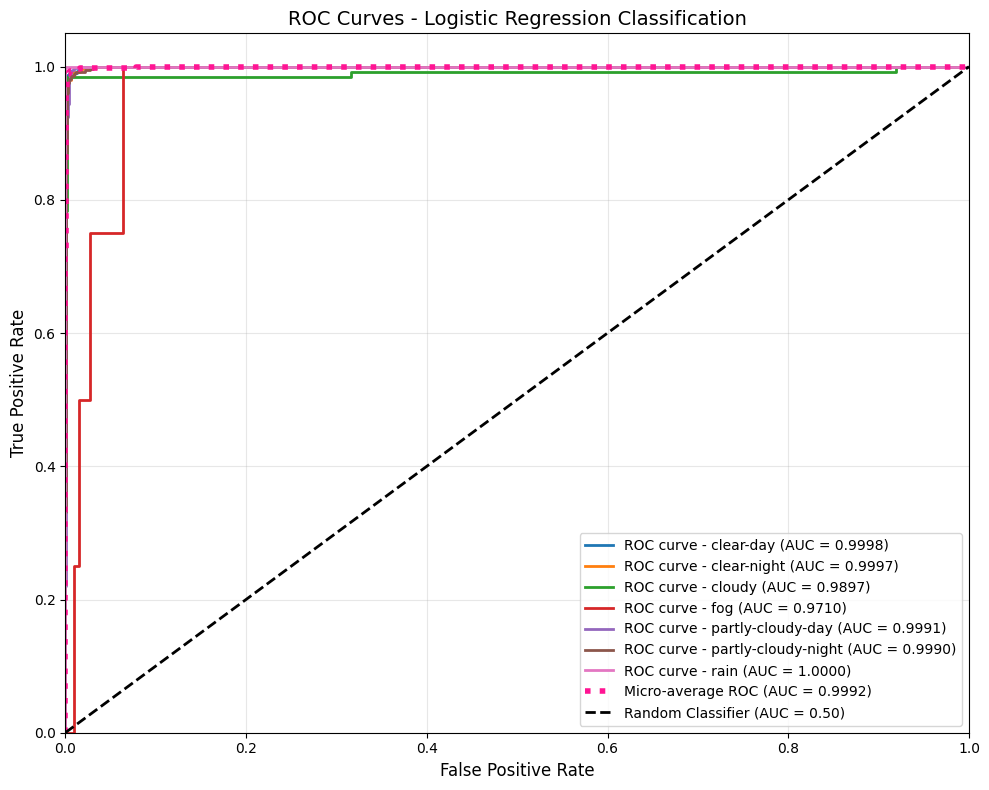

In [231]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [232]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9990
One-vs-One (Weighted)  : 0.9949
Micro-average          : 0.9992


In [233]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': classification_report_dict_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.985631 → 0.985973
   F1-Score: 0.984951 → 0.985294
   AUC (micro-avg): 0.999133 → 0.999165
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [234]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [235]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [236]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.3min remaining:  4.3min


CPU times: user 1.84 s, sys: 578 ms, total: 2.42 s
Wall time: 4min 43s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.7min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [237]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.8s remaining:   30.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s finished


In [238]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [239]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9501
Precision: 0.9506
Recall:    0.9501
F1-Score:  0.9446


In [240]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.94      0.95       301
        clear-night       0.99      0.94      0.96       362
             cloudy       0.98      0.40      0.57       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.92      0.98      0.95       774
partly-cloudy-night       0.93      0.98      0.96       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.95      2923
          macro avg       0.82      0.75      0.77      2923
       weighted avg       0.95      0.95      0.94      2923



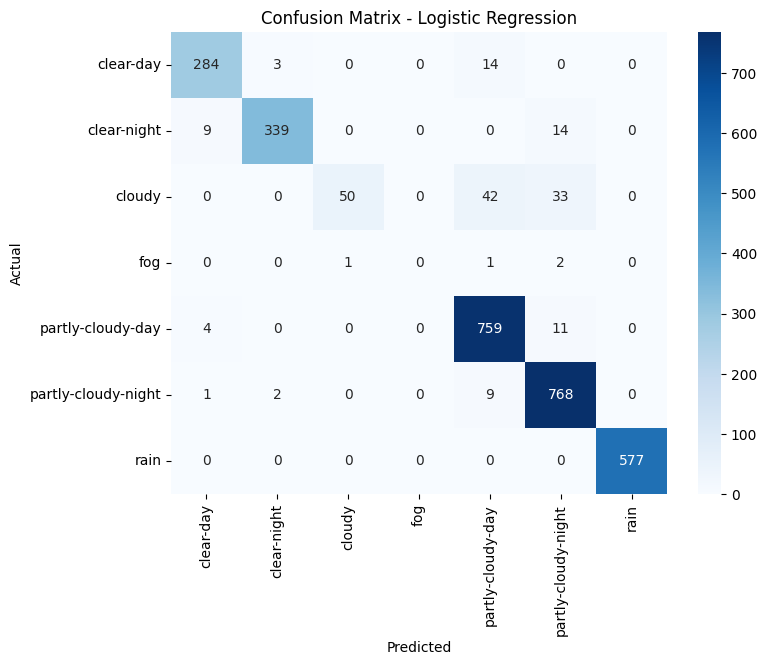

In [241]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [242]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.0s remaining:   31.0s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.7s finished


In [243]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [244]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9982
clear-night : 0.9976
cloudy   : 0.9951
fog      : 0.9964
partly-cloudy-day : 0.9960
partly-cloudy-night : 0.9952
rain     : 1.0000
Micro-avg : 0.9966


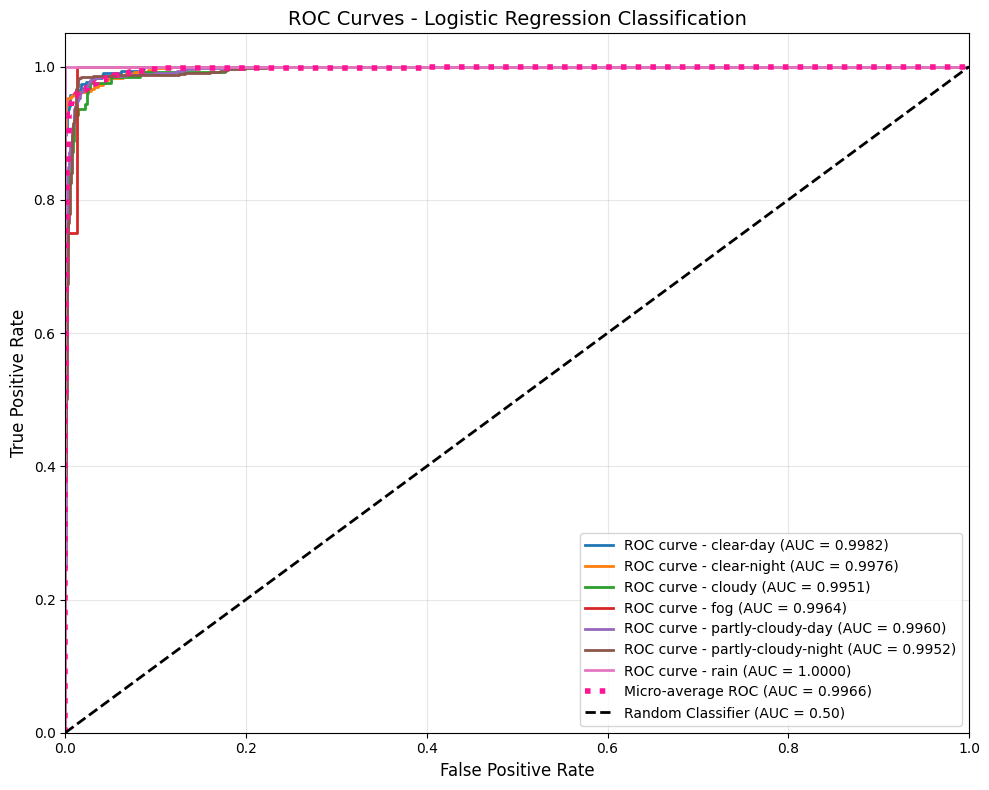

In [245]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [246]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9970
One-vs-One (Weighted)  : 0.9944
Micro-average          : 0.9966


In [247]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.950051, Best Accuracy: 0.960657
   Current F1: 0.944562, Best F1: 0.957527
   Current AUC (micro-avg): 0.996618, Best AUC: 0.997810
   Current Features: 23, Best Features: 27


### Robust Scaler

In [248]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [249]:
X_train

array([[ 0.00000000e+00, -9.16666667e-01,  0.00000000e+00, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  5.83333333e-01,  0.00000000e+00, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01, -7.50000000e-01,  0.00000000e+00, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33333333e-02,  0.00000000e+00, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -2.50000000e-01,  0.00000000e+00, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [250]:
X_test

array([[ 0.8       , -0.91666667,  0.        , ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.75      ,  0.        , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.25      ,  1.        , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.75      ,  0.        , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        ,  0.16666667,  1.        , ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.08333333,  0.        , ...,  0.79384817,
         0.25757576,  0.        ]])

#### Default Parameters

In [251]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [252]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 36.5 s, sys: 613 ms, total: 37.1 s
Wall time: 37.1 s


SVC(probability=True, random_state=42)

In [253]:
y_pred = training_model.predict(X_test)
y_pred

array(['partly-cloudy-night', 'rain', 'rain', ..., 'rain',
       'partly-cloudy-day', 'rain'], dtype=object)

In [254]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [255]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [256]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6599
Precision: 0.5145
Recall:    0.6599
F1-Score:  0.5673


In [257]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.00      0.00      0.00       301
        clear-night       0.00      0.00      0.00       362
             cloudy       0.00      0.00      0.00       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.67      0.75      0.71       774
partly-cloudy-night       0.52      0.99      0.69       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.66      2923
          macro avg       0.31      0.39      0.34      2923
       weighted avg       0.51      0.66      0.57      2923



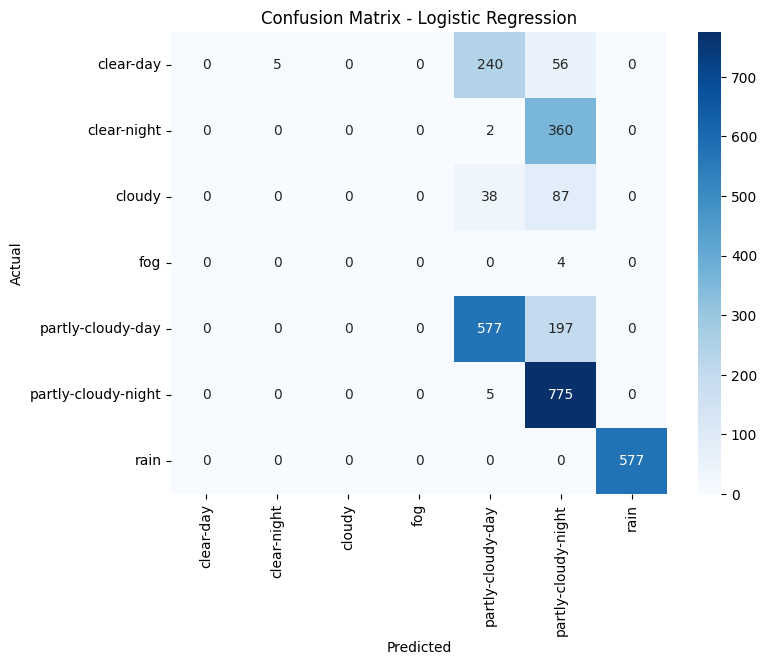

In [258]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [259]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [260]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [261]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9803
clear-night : 0.9685
cloudy   : 0.9290
fog      : 0.9342
partly-cloudy-day : 0.9696
partly-cloudy-night : 0.9746
rain     : 1.0000
Micro-avg : 0.9839


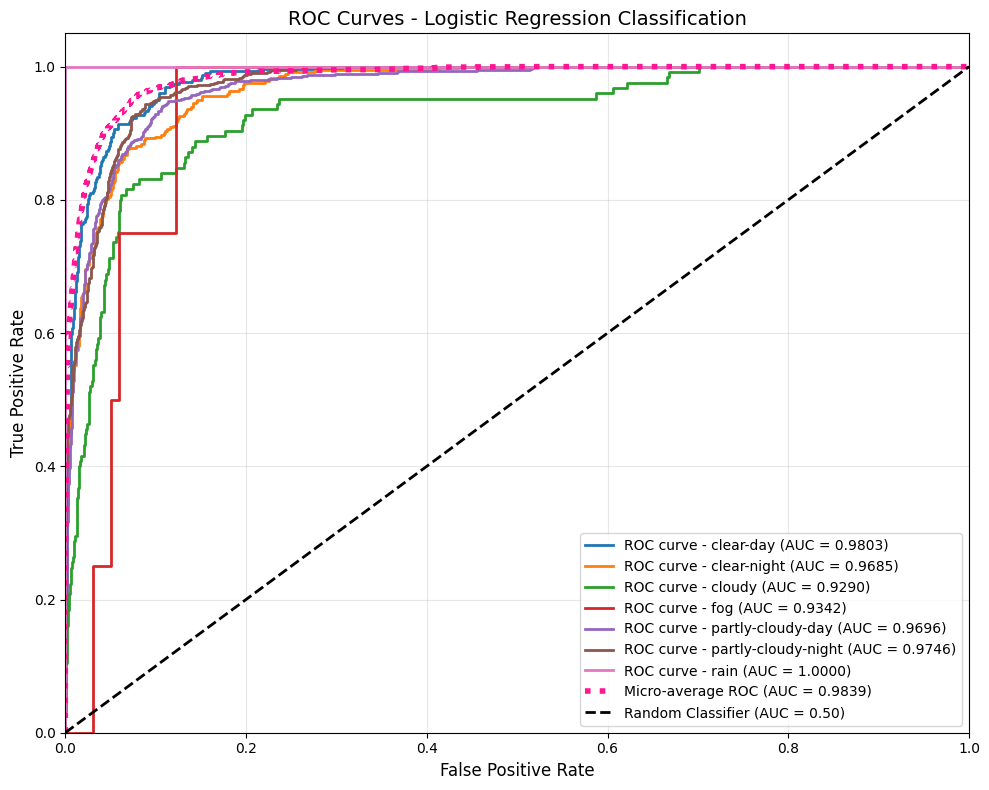

In [262]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [263]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9761
One-vs-One (Weighted)  : 0.9592
Micro-average          : 0.9839


In [264]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.665412 ≈ 0.659938 (similar)
   F1-Score: 0.572020 ≈ 0.567279 (similar)
   AUC (micro-avg): 0.982828 ≈ 0.983924
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [265]:
grid_param_robust = [grid_param_minmax, grid_param_standard]

In [266]:
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param_robust,
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, # allow parallel processing, you cant use your own laptop while this runs
    verbose=1,
    return_train_score=True
)

grid_search

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [267]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 8min 15s, sys: 2.34 s, total: 8min 18s
Wall time: 38min 17s


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [268]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'C': 100, 'class_weight': None, 'coef0': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.9849639763499388


In [269]:
y_pred_grid = best_grid_model.predict(X_test)

In [270]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [271]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9856
Precision: 0.9844
Recall:    0.9856
F1-Score:  0.9850


In [272]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       0.99      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.98      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.84      0.84      0.84      2923
       weighted avg       0.98      0.99      0.98      2923



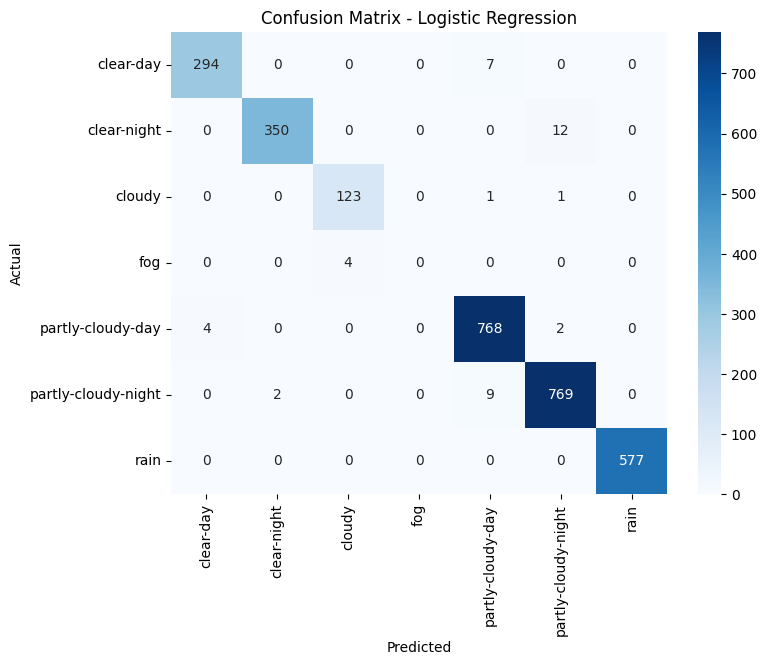

In [273]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [274]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [275]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [276]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 0.9997
cloudy   : 0.9898
fog      : 0.9686
partly-cloudy-day : 0.9990
partly-cloudy-night : 0.9989
rain     : 1.0000
Micro-avg : 0.9991


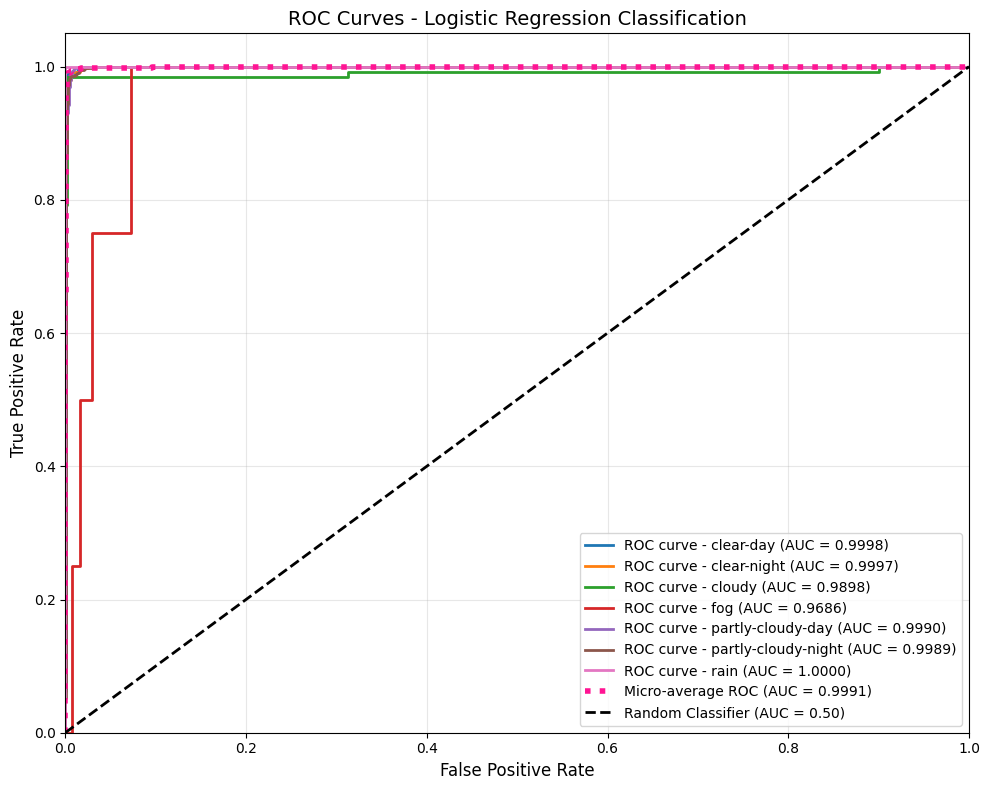

In [277]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [278]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9946
Micro-average          : 0.9991


In [279]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': classification_report_dict_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.985631 ≈ 0.985631 (similar)
   F1-Score: 0.984952 ≈ 0.984951 (similar)
   AUC (micro-avg): 0.999182 ≈ 0.999123
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [280]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [281]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [282]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  9.1min remaining:  9.1min


CPU times: user 3.56 s, sys: 891 ms, total: 4.45 s
Wall time: 9min 19s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.3min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [283]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   49.5s remaining:   49.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   50.9s finished


In [284]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [285]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9073
Precision: 0.9088
Recall:    0.9073
F1-Score:  0.8951


In [286]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.90      0.88      0.89       301
        clear-night       0.91      0.86      0.88       362
             cloudy       0.95      0.16      0.27       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.88      0.95      0.91       774
partly-cloudy-night       0.88      0.95      0.91       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.91      2923
          macro avg       0.79      0.69      0.70      2923
       weighted avg       0.91      0.91      0.90      2923



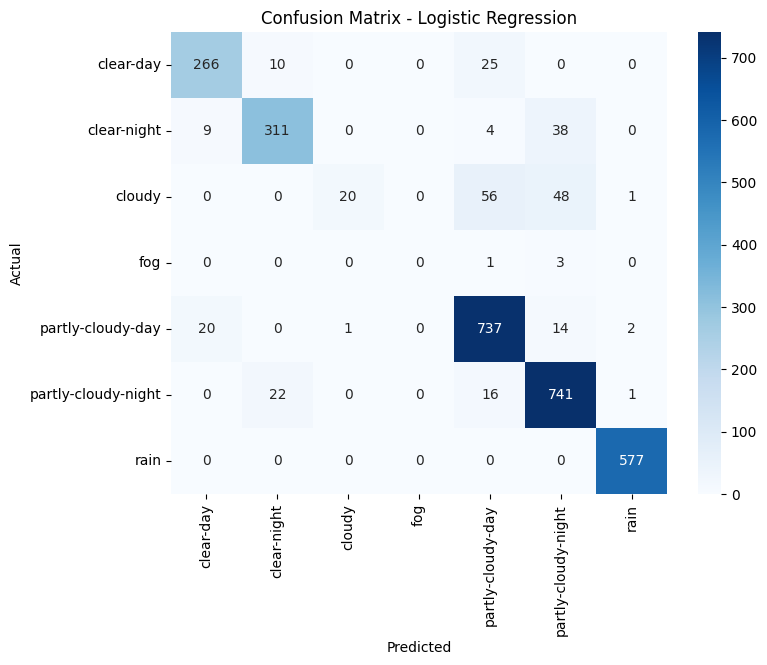

In [287]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [288]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   49.3s remaining:   49.3s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   50.2s finished


In [289]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [290]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9943
clear-night : 0.9889
cloudy   : 0.9843
fog      : 0.9806
partly-cloudy-day : 0.9860
partly-cloudy-night : 0.9901
rain     : 1.0000
Micro-avg : 0.9927


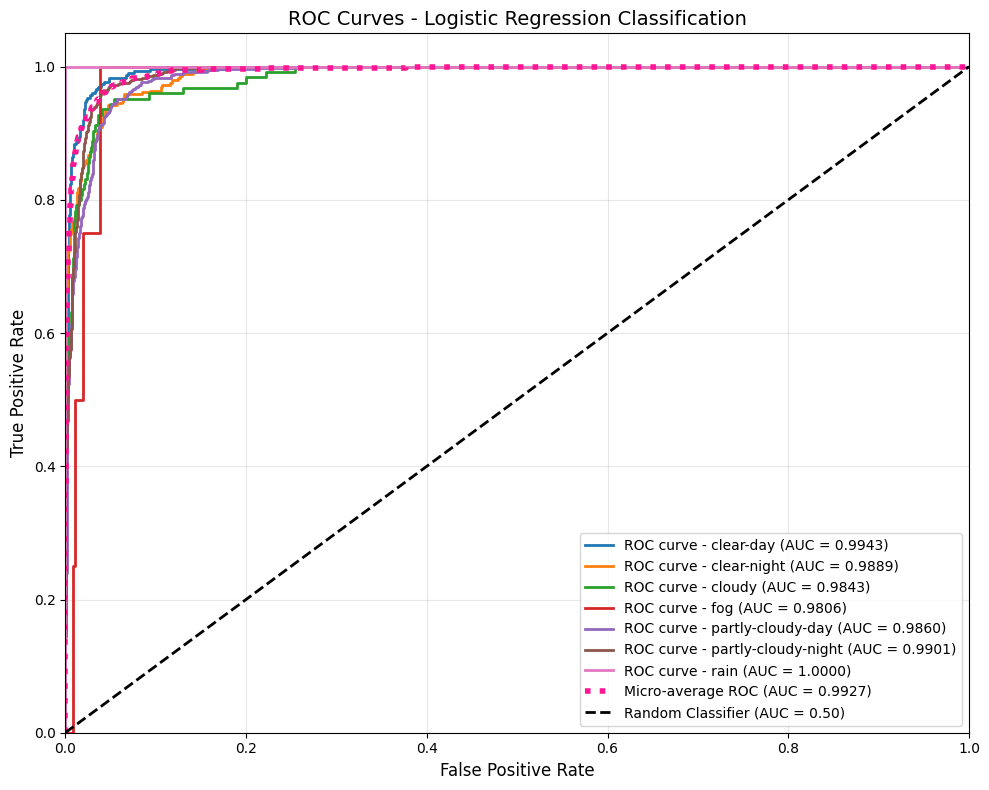

In [291]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [292]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9910
One-vs-One (Weighted)  : 0.9841
Micro-average          : 0.9927


In [293]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.907287, Best Accuracy: 0.919603
   Current F1: 0.895112, Best F1: 0.909021
   Current AUC (micro-avg): 0.992723, Best AUC: 0.994800
   Current Features: 23, Best Features: 27


# All Performance

In [294]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
      Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
   SVC Grid StandardScaler   Icon        23 0.985973  0.984690 0.985973 0.985294
   SVC Grid   RobustScaler   Icon        23 0.985631  0.984359 0.985631 0.984951
   SVC Grid   MinMaxScaler   Icon        23 0.985631  0.984376 0.985631 0.984948
SVC Bagging StandardScaler   Icon        27 0.960657  0.960569 0.960657 0.957527
SVC Bagging   MinMaxScaler   Icon        23 0.958262  0.957687 0.958262 0.955470
        SVC StandardScaler   Icon        23 0.942525  0.941849 0.942525 0.930371
        SVC   MinMaxScaler   Icon        23 0.939446  0.942633 0.939446 0.925205
SVC Bagging   RobustScaler   Icon        27 0.919603  0.918297 0.919603 0.909021
        SVC   RobustScaler   Icon        23 0.659938  0.514477 0.659938 0.567279

📈 Total models shown: 9
🏆 Best F1-Score: 0.985294 (SVC Grid + StandardScaler for Icon)


# <center><font size="50" color="red">Thank You</font></center>